In [13]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import PIL.Image as Image

torch.Size([64, 3, 256, 256])


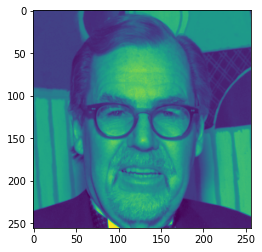

In [14]:
# load data

train_set = datasets.ImageFolder('./00000',transform=transforms.Compose([
                                                transforms.Resize([256,256]),
                                                transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# print(train_loader.shape)
for data, targets in train_loader:
    break
print(data.shape)
plt.imshow(data[0,0,:,:]*255)
plt.show()

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
# G U-Net

# Conv block
class Conv(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Conv,self).__init__()

        # same size
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1,bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3,padding=1,bias=False),
            nn.LeakyReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.double_conv(x)

# Super resloution
class superR(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(superR,self).__init__()

        self.deConv = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,3,stride=2),
        )

class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()

        self.down1 = Conv(3,64)
        self.down2 = Conv(64,128)
        self.down3 = Conv(128,256)
        self.down4 = Conv(256,512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)

        self.up3 = Conv(256+512,256)
        self.up2 = Conv(128+256,128)
        self.up1 = Conv(64+128,64)

    def forward(self,x):
        # encode
        conv1 = self.down1(x)
        x = self.maxpool(conv1)
        print('1',x.shape)

        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        print('2',x.shape)

        conv3 = self.down3(x)
        x = self.maxpool(conv3)
        print('3',x.shape)

        x = self.down4(x)
        print('4',x.shape)

        # decode
        x = self.upsample(x)
        x = torch.cat([x,conv3],dim=1)
        x = self.up3(x)
        print('5',x.shape)

        x = self.upsample(x)
        x = torch.cat([x,conv2],dim=1)
        x = self.up2(x)
        print('6',x.shape)

        x = self.upsample(x)
        x = torch.cat([x,conv1],dim=1)
        x = self.up1(x)

        return x








In [18]:
# test shape

model = UNet()
x = torch.randn(1,3,64,64)
y = model(x)
print(y.shape,y)


1 torch.Size([64, 64, 128, 128])
2 torch.Size([64, 128, 64, 64])
3 torch.Size([64, 256, 32, 32])
4 torch.Size([64, 512, 32, 32])
5 torch.Size([64, 256, 64, 64])
6 torch.Size([64, 128, 128, 128])


KeyboardInterrupt: 